In [11]:
import numpy as np
import matplotlib.pyplot as plt

In [12]:
class BernoulliBandit:
    """伯努利多臂老虎机,输入K表示拉杆个数"""
    def __init__(self, K):
        # np.random.uniform(low=0,high=1,size) [low,high)
        self.probs = np.random.uniform(size=K)
        # 概率
        self.best_idx = np.argmax(self.probs)
        self.best_prob = self.probs[self.best_idx]
        self.K = K
    
    def step(self, k):
        if np.random.rand() < self.probs[k]:
            return 1
        else:
            return 0


In [13]:
np.random.seed(1)
K = 10
bandit_10_arm = BernoulliBandit(K)
print("随机生成了一个%d臂伯努利老虎机" % K)
print("获奖概率最大的拉杆为%d号,其获奖概率为%.4f" %
      (bandit_10_arm.best_idx, bandit_10_arm.best_prob))

随机生成了一个10臂伯努利老虎机
获奖概率最大的拉杆为1号,其获奖概率为0.7203


In [14]:
class Solver:
    def __init__(self, bandit):
        self.bandit = bandit
        self.counts = np.zeros(self.bandit.K)
        self.regret = 0
        self.actions = []
        self.regrets = []

    def update_regret(self, k):
        self.regret += self.bandit.best_prob - self.bandit.probs[k]
        self.regrets.append(self.regret)

    def run_one_step(self):
        raise NotImplementedError
    
    def run(self, num_steps):
        for _ in range(num_steps):
            k = self.run_one_step()
            self.counts[k] += 1
            self.actions.append(k)
            self.update_regret(k)

In [15]:
class EpsilonGreedy(Solver):
    def __init__(self, bandit, epsilon=0.01, init_prob=1.0):
        super(EpsilonGreedy, self).__init__(bandit)
        self.epsilon = epsilon
        self.estimates = np.array([init_prob] * self.bandit.K)
    
    def run_one_step(self):
        if np.random.random() < self.epsilon:
            k = np.random.randint(0, self.bandit.K)
        else:
            k = np.argmax(self.estimates) #选择期望奖励估值最大的拉杆
        r = self.bandit.step(k) # 得到本次动作的奖励
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])
        return k

In [16]:
def plot_results(solvers, solver_names):
    """生成累积懊悔随时间变化的图像。输入solvers是一个列表,列表中的每个元素是一种特定的策略。
    而solver_names也是一个列表,存储每个策略的名称"""
    for idx, solver in enumerate(solvers):
        time_list = range(len(solver.regrets))
        plt.plot(time_list, solver.regrets, label=solver_names[idx])
    plt.xlabel('Time steps')
    plt.ylabel('Cumulative regrets')
    plt.title('%d-armed bandit' % solvers[0].bandit.K)
    plt.legend()
    plt.show()

epsilon-贪婪算法的累积懊悔为： 25.526630933945313


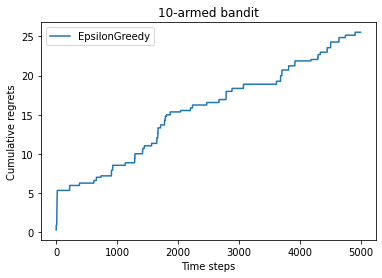

In [17]:
np.random.seed(1)
epsilon_greedy_solver = EpsilonGreedy(bandit_10_arm, epsilon=0.01)
epsilon_greedy_solver.run(5000)
print('epsilon-贪婪算法的累积懊悔为：', epsilon_greedy_solver.regret)
plot_results([epsilon_greedy_solver], ["EpsilonGreedy"])

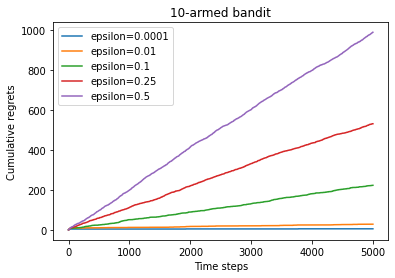

In [18]:
np.random.seed(0)
epsilons = [1e-4, 0.01, 0.1, 0.25, 0.5]
epsilon_greedy_solver_list = [
    EpsilonGreedy(bandit_10_arm, epsilon=e) for e in epsilons
]
epsilon_greedy_solver_names = ["epsilon={}".format(e) for e in epsilons]
for solver in epsilon_greedy_solver_list:
    solver.run(5000)

plot_results(epsilon_greedy_solver_list, epsilon_greedy_solver_names)

epsilon值衰减的贪婪算法的累积懊悔为： 10.114334931260183


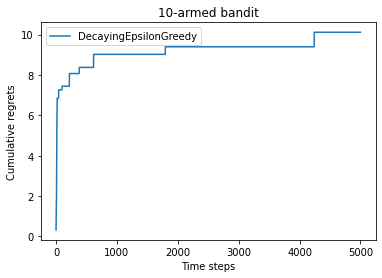

In [19]:
class DecayingEpsilonGreedy(Solver):
    """ epsilon值随时间衰减的epsilon-贪婪算法,继承Solver类 """
    def __init__(self, bandit, init_prob=1.0):
        super(DecayingEpsilonGreedy, self).__init__(bandit)
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.total_count = 0

    def run_one_step(self):
        self.total_count += 1
        if np.random.random() < 1 / self.total_count:  # epsilon值随时间衰减
            k = np.random.randint(0, self.bandit.K)
        else:
            k = np.argmax(self.estimates)

        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])
        return k


np.random.seed(1)
decaying_epsilon_greedy_solver = DecayingEpsilonGreedy(bandit_10_arm)
decaying_epsilon_greedy_solver.run(5000)
print('epsilon值衰减的贪婪算法的累积懊悔为：', decaying_epsilon_greedy_solver.regret)
plot_results([decaying_epsilon_greedy_solver], ["DecayingEpsilonGreedy"])

上置信界算法的累积懊悔为： 70.45281214197854


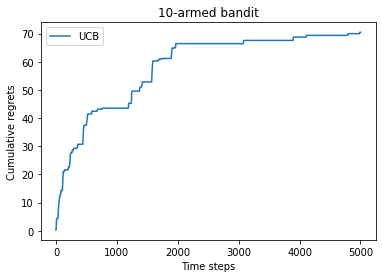

In [20]:
class UCB(Solver):
    """UCB算法, 继承Solver类"""
    def __init__(self, bandit, coef, init_prob=1.0):
        super(UCB, self).__init__(bandit)
        self.total_count = 0
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.coef = coef
    
    def run_one_step(self):
        self.total_count += 1
        ucb = self.estimates + self.coef * np.sqrt(
            np.log(self.total_count) / (2 * (self.counts + 1))
        )
        k = np.argmax(ucb)
        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (
            r - self.estimates[k]
        )
        return k

np.random.seed(1)
coef = 1 # 控制不确定性比重的系数
UCB_solver = UCB(bandit_10_arm, coef)
UCB_solver.run(5000)
print('上置信界算法的累积懊悔为：', UCB_solver.regret)
plot_results([UCB_solver], ["UCB"])

汤普森采样算法的累积懊悔为： 57.19161964443925


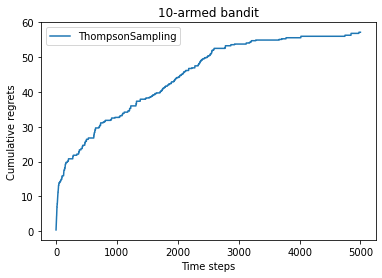

In [22]:
class ThompsonSampling(Solver):
    """ 汤普森采样算法,继承Solver类"""
    def __init__(self, bandit):
        super(ThompsonSampling, self).__init__(bandit)
        self._a = np.ones(self.bandit.K)
        self._b = np.ones(self.bandit.K)

    def run_one_step(self):
        samples = np.random.beta(self._a, self._b) #
        k = np.argmax(samples)
        r = self.bandit.step(k)

        self._a[k] += r
        self._b[k] += (1 - r)
        return k

np.random.seed(1)
thompson_sampling_solver = ThompsonSampling(bandit_10_arm)
thompson_sampling_solver.run(5000)
print('汤普森采样算法的累积懊悔为：', thompson_sampling_solver.regret)
plot_results([thompson_sampling_solver], ["ThompsonSampling"])

## 总结
探索与利用是与环境做交互学习的重要问题，是强化学习试错法中的必备技术，而多臂老虎机问题是研究探索与利用技术理论的最佳环境。了解多臂老虎机的探索与利用问题，对接下来我们学习强化学习环境探索有很重要的帮助。对于多臂老虎机各种算法的累积懊悔理论分析，有兴趣的同学可以自行查阅相关资料。 -贪婪算法、上置信界算法和汤普森采样算法在多臂老虎机问题中十分常用，其中上置信界算法和汤普森采样方法均能保证对数的渐进最优累积懊悔。

多臂老虎机问题与强化学习的一大区别在于其与环境的交互并不会改变环境，即多臂老虎机的每次交互的结果和以往的动作无关，所以可看作无状态的强化学习（stateless reinforcement learning）。第 3 章将开始在有状态的环境下讨论强化学习，即马尔可夫决策过程。